# Install and Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import libraries

# packages for Vietnamese
!pip install underthesea

import requests
import nltk
import math
import re
import regex as re
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json

#You will need to download some packages from NLTK. 

from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
!pip install advertools

import advertools as adv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Crawling

## Extracting hrefs

We will scrape the "browse" page to get individual href links for each product and store those links for extraction function.

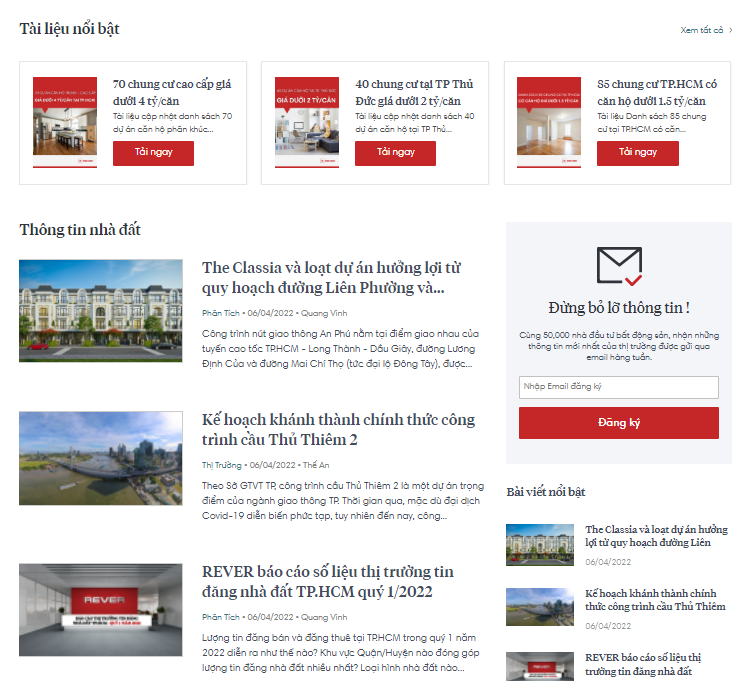

In [ ]:
##### GET LINKS FROM HOMEPAGE (LIMITED TO NUM_PAGES)
def getHomePageHrefs(num_pages):
  def get_hrefs(page,class_name):
    page=requests.get(page)
    soup=BeautifulSoup(page.text,'html.parser')
    container=soup.find_all('div',{'class':class_name})
    container_a=container[0].find_all('a')
    links=[container_a[i].get('href') for i in range(len(container_a))]
    for link in links:
      #print(link)
      if link==None:
        continue
      if 'topic' not in link and 'author' not in link and 'https' in link:
        hrefs.append(link)

  urls = ['https://blog.rever.vn/page/{}'.format(i+1) for i in range(num_pages)] # actually, 369
  hrefs = []
  for url in urls:
    get_hrefs(url,'post-listing')
  hrefs=set(hrefs)
  return hrefs

In [ ]:
h = getHomePageHrefs(2)
h

# Web Extraction

In [59]:
####### GET EACH LINK'S INFO USING ITS HREF
def getHomePageInfo(hrefs,write=False):
  dates = []
  titles = []
  content_text = []

  def get_date(soup):
    try:
      data=soup.find('p',{'class':'date-post'}).contents
      dates.append(data[0])
    except Exception:
      dates.append('')
      pass

  #Function to extract product title
  def get_title(soup):
    try:
      title=soup.find('title').contents
      titles.append(title[0])
    except Exception:
      titles.append('')
      pass

  #Function to extract product's text contents
  def get_contents(soup): 
    try:
      # find author as the endpoint
      author = soup.find("meta", attrs={'name':'author'})["content"]
      parents_blacklist=['[document]','html','head',
                        'style','script','body',
                        'div','a','section','tr',
                        'td','label','ul','header',
                        'aside',]
      content=''
      text=soup.find_all(text=True)
      
      for t in text:
        if t.parent.name not in parents_blacklist and len(t) > 10:
          content=content+t+' '
      content = content[0:content.rfind(author)]
      content = content[0:content.find('HubSpot Call-to-Action Code')]
      content_text.append(content)
    except Exception:
      content_text.append('')
      pass

  iteration=1
  for href in hrefs:
    print('Web scraping: iteration',iteration,'/',len(hrefs))
    page=requests.get(href)
    soup=BeautifulSoup(page.text,'html.parser')
    get_date(soup)
    get_title(soup)
    get_contents(soup)
    iteration+=1
  print('Processing to dataframe...')
  df = pd.DataFrame(list(zip(dates,titles,content_text,hrefs)), 
                    columns = ['date','title','content','link'])
  signs = ['\n', ' /', ', ', '"',"'",": "]
  for sign in signs:
    df = df.replace(sign,' ', regex=True) 
  df = df.replace(r'\s+',' ', regex=True) 
  mask = (df['content'].str.len() > 150)
  df = df.loc[mask]
  df.dropna(subset=['content'], inplace=True)
  if write:
    from datetime import datetime
    today = datetime.today().strftime('%Y-%m-%d')
    df.to_csv('rever_data_{}_{}link'.format(today,len(hrefs)),index=False)

  return df

In [ ]:
df = getHomePageInfo(h,write=True)
df

# Natural Language Processing

## Get data from CSV file

In [79]:
df = pd.read_csv("/content/rever_data_2022-04-25_38link")
df.head()

## Tokenize

In [78]:
###### TOKENIZE SENTENCES INTO MEANINGFUL CHUNKS
def tokenizer(df):
  from underthesea import word_tokenize
  stop_words=set(adv.stopwords['vietnamese'])
  df['title'] = df['title'].map(lambda x:word_tokenize(x))
  df['content'] = df['content'].map(lambda x:word_tokenize(str(x)))
  
  # handle unnecessary tokens: stopwords, digit, sign (comma, dot,brackets,..)
  df['title'] = df['title'].map(lambda x:[w.lower() for w in x if w.replace(' ','_') not in stop_words and not w.isdigit() and len(w)>1])
  df['content'] = df['content'].map(lambda x:[w for w in x if w not in stop_words and not w.isdigit() and len(w)>1])
  df['content'] = df['content'].map(lambda x:' '.join(x).lower())

In [80]:
tokenizer(df)
df

,date,title,content,link
0,04/22/2022,"[điểm, mặt, dự án, cửa, trung tâm, thương mại]",điểm mặt dự án cửa trung tâm thương mại 546 đi...,https://blog.rever.vn/diem-mat-nhung-du-an-co-...
1,04/25/2022,"[câu, hối hận, mua, đầu]",câu nhất định phải biết hối hận mua đầu câu nh...,https://blog.rever.vn/13-cau-hoi-ban-nhat-dinh...
2,04/12/2022,"[sống, chung cư, gia đình, lưu ý, kỹ]",sống chung cư gia đình lưu ý kỹ sống chung cư ...,https://blog.rever.vn/song-o-chung-cu-gia-dinh...
3,04/12/2022,"[công bố, top, chủ, đầu tư, bất động sản, uy tín]",công bố top chủ đầu tư bất động sản uy tín côn...,https://blog.rever.vn/top-10-chu-dau-tu-bat-do...
4,04/14/2022,"[cập nhật, tiến độ, thi công, dự án, mt eastma...",cập nhật tiến độ thi công dự án mt eastmark ci...,https://blog.rever.vn/tien-do-du-an-mt-eastmar...
5,04/19/2022,"[phân tích, đánh giá, chi tiết, dự án, king cr...",phân tích đánh giá chi tiết dự án king crown i...,https://blog.rever.vn/phan-tich-danh-gia-du-an...
6,04/24/2022,"[kinh nghiệm, đầu tư, bất động sản, vốn]",kinh nghiệm đầu tư bất động sản vốn kinh nghiệ...,https://blog.rever.vn/kinh-nghiem-dau-tu-bat-d...
7,04/19/2022,"[phân tích, đánh giá, chi tiết, dự án, the bev...",phân tích đánh giá chi tiết dự án the beverly ...,https://blog.rever.vn/phan-tich-va-danh-gia-du...
8,09/08/2021,"[phải biết, nguyên tắc, đầu tư, bất động sản, ...",phải biết nguyên tắc đầu tư bất động sản hiệu ...,https://blog.rever.vn/8-nguyen-tac-dau-tu-bat-...
9,04/25/2022,"[mua, căn hộ, the beverly solari]",lý do mua căn hộ the beverly solari thời điểm ...,https://blog.rever.vn/ly-do-mua-the-beverly-so...


## Get keywords from content: TF-IDF

Basically, TF-IDF models measure how often a term or word was used within a single document, then compares that to its average usage throughout the entire corpus of documents.

In [87]:
###### GET KEYWORDS WITH LENGTH FOR EACH LINK
def get_keywords(df, content_list,ngrams):
  kw = []
  #The first function pre-processes text by lowering the case of characters, 
  #and removing special characters. 
  def pre_process(text):
      text=text.lower()
      text=re.sub("</?.*?>"," <> ",text)
      text=re.sub("(\\d|\\W)+"," ",text)
      return text

  #This function maps matrices to coordinates. The TF-IDF function maps 
  #Frequency scores to matrices, which then need to be sorted to help us find our keywords. 

  def sort_coo(coo_matrix):
      tuples = zip(coo_matrix.col, coo_matrix.data)
      return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

  #As with above, this is a helper function that will assist in the sorting and
  #selection of keywords once the frequencies have been mapped to matrices. 
  #This function specifically helps us to choose the most relevant keywords, 
  #based on TF-IDF statistics

  def extract_topn_from_vector(feature_names, sorted_items, topn=10):
      sorted_items = sorted_items[:topn]
      score_vals = []
      feature_vals = []

      for idx, score in sorted_items:
          fname = feature_names[idx]
          score_vals.append(round(score, 3))
          feature_vals.append(feature_names[idx])

      results= {}
      for idx in range(len(feature_vals)):
          results[feature_vals[idx]]=score_vals[idx]
      return results

  #The final function, which incorporates the above helper functions, 
  #Applies a TF-IDF algorithm to the body of our text to find keywords based
  #on frequency of usage. 
  
  iteration=1
  processed_text=[pre_process(text) for text in content_list]

  stop_words=set(adv.stopwords['vietnamese'])

  cv=CountVectorizer(max_df=0.7,stop_words=stop_words,ngram_range = ((ngrams,ngrams)))
  word_count_vector=cv.fit_transform(processed_text)
  tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
  tfidf_transformer.fit(word_count_vector)

  feature_names=cv.get_feature_names_out()

  for i in range(len(processed_text)):
    print('Getting Keywords',iteration,'/',len(content_list))
    doc=processed_text[i]
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keys=extract_topn_from_vector(feature_names,sorted_items,10)
    kw.append(list(keys.keys()))
    iteration+=1
  return kw

In [88]:
content_list = df['content'].tolist()
kw1 = get_keywords(df,content_list,1)
kw2 = get_keywords(df,content_list,2)
kw3 = get_keywords(df,content_list,3)
df['Keyword_1'] = kw1
df['Keyword_2'] = kw2
df['Keyword_3'] = kw3

df = df.sort_values(by="date")
df

Getting Keywords 1 / 36
Getting Keywords 2 / 36
Getting Keywords 3 / 36
Getting Keywords 4 / 36
Getting Keywords 5 / 36
Getting Keywords 6 / 36
Getting Keywords 7 / 36
Getting Keywords 8 / 36
Getting Keywords 9 / 36
Getting Keywords 10 / 36
Getting Keywords 11 / 36
Getting Keywords 12 / 36
Getting Keywords 13 / 36
Getting Keywords 14 / 36
Getting Keywords 15 / 36
Getting Keywords 16 / 36
Getting Keywords 17 / 36
Getting Keywords 18 / 36
Getting Keywords 19 / 36
Getting Keywords 20 / 36
Getting Keywords 21 / 36
Getting Keywords 22 / 36
Getting Keywords 23 / 36
Getting Keywords 24 / 36
Getting Keywords 25 / 36
Getting Keywords 26 / 36
Getting Keywords 27 / 36
Getting Keywords 28 / 36
Getting Keywords 29 / 36
Getting Keywords 30 / 36
Getting Keywords 31 / 36
Getting Keywords 32 / 36
Getting Keywords 33 / 36
Getting Keywords 34 / 36
Getting Keywords 35 / 36
Getting Keywords 36 / 36
Getting Keywords 1 / 36
Getting Keywords 2 / 36
Getting Keywords 3 / 36
Getting Keywords 4 / 36
Getting Keywo

,date,title,content,link,Keyword_1,Keyword_2,Keyword_3
2,04/12/2022,"[sống, chung cư, gia đình, lưu ý, kỹ]",sống chung cư gia đình lưu ý kỹ sống chung cư ...,https://blog.rever.vn/song-o-chung-cu-gia-dinh...,"[ban, cư, đình, thiết, sống, kế, lan, can, hộ,...","[ban công, kế ban, gia đình, sống cư, thiết kế...","[thiết kế ban, kế ban công, đình lưu kỹ, sống ..."
3,04/12/2022,"[công bố, top, chủ, đầu tư, bất động sản, uy tín]",công bố top chủ đầu tư bất động sản uy tín côn...,https://blog.rever.vn/top-10-chu-dau-tu-bat-do...,"[uy, tín, sản, động, bất, phát, chủ, ty, triển...","[sản uy, uy tín, động sản, bất động, chủ đầu, ...","[động sản uy, sản uy tín, bất động sản, chủ đầ..."
31,04/12/2022,"[công bố, top, nhà thầu, xây dựng, uy tín]",công bố top nhà thầu xây dựng uy tín công bố t...,https://blog.rever.vn/top-10-nha-thau-xay-dung...,"[top, uy, dựng, xây, tín, bố, thầu, xd, vlxd, ty]","[bố top, công bố, xây dựng, uy tín, top thầu, ...","[công bố top, xây dựng uy, top thầu xây, dựng ..."
27,04/12/2022,"[trong, capitaland, khởi công, dự án, quy mô, ...",trong capitaland khởi công dự án quy mô ha bìn...,https://blog.rever.vn/capitaland-khoi-cong-du-...,"[dương, capitaland, cld, cư, dân, khu, bình, m...","[bình dương, khu dân, dân cư, án quy, quy mô, ...","[khu dân cư, án quy mô, dự án quy, thành phố b..."
17,04/13/2022,"[toàn cảnh, quy hoạch, kđt, thủ thiêm, quy chế...",toàn cảnh quy hoạch kđt thủ thiêm quy chế kiến...,https://blog.rever.vn/quy-hoach-kdt-thu-thiem-...,"[đồ, sơ, thiêm, khu, đô, thủ, thị, quy, trúc, ...","[sơ đồ, thiêm sơ, thị thủ, thủ thiêm, khu đô, ...","[thủ thiêm sơ, thiêm sơ đồ, đô thị thủ, thị th..."
23,04/13/2022,"[giấy tờ, mua, giao dịch]",giấy tờ mua chuẩn bị giao dịch giấy tờ mua chu...,https://blog.rever.vn/8-loai-giay-to-nguoi-mua...,"[giấy, tờ, hôn, mua, chứng, khẩu, chuẩn, đồng,...","[giấy tờ, hợp đồng, hộ khẩu, chứng minh, kết h...","[sổ hộ khẩu, minh nhân dân, giấy tờ mua, chứng..."
34,04/13/2022,"[đi, nét, tương đồng, the classia, verosa park]",đi nét tương đồng the classia verosa park đi n...,https://blog.rever.vn/nhung-net-tuong-dong-giu...,"[nét, verosa, classia, tương, đồng, park, đi, ...","[tương đồng, nét tương, verosa park, đồng the,...","[nét tương đồng, đồng the classia, đi nét tươn..."
10,04/14/2022,"[lưu ý, mua, đất, dự án, đầu]",lưu ý mua đất dự án đầu lưu ý mua đất dự án đầ...,https://blog.rever.vn/5-luu-y-nguoi-mua-dat-ne...,"[lưu, mua, đất, tờ, ràng, kỹ, sổ, giấy, pháp, ...","[mua đất, lưu mua, án đầu, đất dự, đầu mua, đầ...","[mua đất dự, lưu mua đất, dự án đầu, đất dự án..."
25,04/14/2022,"[những, lợi ích, mua, căn hộ, bàn giao]",những lợi ích mua căn hộ bàn giao những lợi íc...,https://blog.rever.vn/nhung-loi-ich-ban-nhan-d...,"[mua, hộ, bàn, giao, hàng, rever, tận, vay, ch...","[bàn giao, hộ bàn, ngân hàng, tp hồ, hồ chí, m...","[hộ bàn giao, mua hộ bàn, tp hồ chí, chứng chấ..."
4,04/14/2022,"[cập nhật, tiến độ, thi công, dự án, mt eastma...",cập nhật tiến độ thi công dự án mt eastmark ci...,https://blog.rever.vn/tien-do-du-an-mt-eastmar...,"[eastmark, mt, city, ảnh, thi, tiến, độ, nhật,...","[mt eastmark, eastmark city, ảnh chủ, án mt, n...","[mt eastmark city, ảnh chủ đầu, án mt eastmark..."


# Output

In [91]:
df.to_csv('result.csv',index=False)